In [2]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.simplefilter(action='ignore')

from utils.model import assign_roles

mutations = {
    'CB': ['CM', 'LB', 'RB'],
    'CM': ['CB', 'LB', 'RB', 'LW', 'RW', 'ST'],
    'LB': ['CB', 'LW', 'CM'],
    'RB': ['CB', 'RW', 'CM'],
    'LW': ['LB', 'ST', 'CM'],
    'RW': ['RB', 'ST', 'CM'],
    'ST': ['LW', 'RW', 'CM']
}

positions = ['CB', 'CM', 'LB', 'RB', 'LW', 'RW', 'ST']
ps = [0.25, 0.25, 0.1, 0.1, 0.075, 0.075, 0.15]

population_size_init = 50
n_generations = 1000

#PUT IT TOGETHER
pen = -500

def adaptive_scaling(probas, i):
    lower_p = np.percentile(probas, 50)
    upper_p = np.percentile(probas, 50)

    if i < 200:
        probas[(probas > upper_p) & (probas != 1)] = probas[(probas > upper_p) & (probas != 1)]*0.7
        probas[probas < lower_p] = probas[probas < lower_p]*1.42
    elif i > 400:
        probas[(probas > upper_p) & (probas != 1)] = probas[(probas > upper_p) & (probas != 1)]*1.17
        probas[probas < lower_p] = probas[probas < lower_p]*0.85

    return probas

def random_mix(X, Y):
    choice = np.random.randint(2, size = X.size).reshape(X.shape).astype(bool)
    return np.where(choice, X, Y)

def select(proba):
    return random.random() < proba

#TODO optimize
def mutate(assignment, i):
    for i in range(0, len(assignment)):
        if i < 200:
            if random.random() < 0.1:
                assignment[i] = np.random.choice(positions, 1)[0]
        if i > 200:
            if random.random() < 0.65:
                assignment[i] = np.random.choice(mutations[assignment[i]], 1)[0]

    return assignment

def fitness(proba_df, assignment):
    score = 0
    for i, row in proba_df.iterrows():
        score += row[assignment[i]]

        #penalize very improbable assignments
        min_pen, max_pen = 200, 500
        if row[assignment[i]] < 10:
            score -= max_pen - ((row[assignment[i]]-0)/((10-0)/(max_pen-min_pen)) + min_pen) +min_pen

    if not 'LB' in assignment:
        score += pen
    if not 'RB' in assignment:
        score += pen
    if ('LW' in assignment and 'RW' not in assignment) or ('RW' in assignment and 'LW' not in assignment):
        score += pen
    if np.count_nonzero(assignment == 'LB') > 1:
        score += pen
    if np.count_nonzero(assignment == 'RB') > 1:
        score += pen
    if np.count_nonzero(assignment == 'LW') > 1:
        score += pen
    if np.count_nonzero(assignment == 'RW') > 1:
        score += pen
    if np.count_nonzero(assignment == 'CB') > 3:
        score += pen
    if np.count_nonzero(assignment == 'CM') > 4:
        score += pen
    if np.count_nonzero(assignment == 'CM') < 2:
        score += pen
    if np.count_nonzero(assignment == 'ST') > 2:
        score += pen
    if np.count_nonzero(assignment == 'ST') < 1:
        score += pen
    if np.count_nonzero(assignment == 'CB') <= 1:
        score += pen
    # if np.count_nonzero(assignment == 'ST') == 2:
    #     strikers_idx = assignment == 'ST'
    #     strikers_y = proba_df.iloc[strikers_idx]['y']

    #     if strikers_y.max() - strikers_y.min() > 30:
    #         score += pen
    if np.count_nonzero(assignment == 'ST') == 1:
        striker_idx = assignment == 'ST'
        striker_x = proba_df.iloc[striker_idx]['x'].values[0]

        if proba_df.loc[proba_df['x'] < striker_x].shape[0] < 3:
            score += pen
    if np.count_nonzero(assignment == 'CB') == 3:
        cbs_idx = assignment == 'CB'
        cbs = proba_df.iloc[cbs_idx]
        
        cb_left = cbs['y'].idxmin()
        cb_right = cbs['y'].idxmax()
        cb_center = list(cbs['y'].loc[(cbs.index != cb_left) & (cbs.index != cb_right)].index)[0]

        cb_highest = cbs['x'].idxmax()
        if cb_center == cb_highest:
            if cbs.loc[cb_highest]['x'] - cbs['x'].median() > 3:
                score += pen
        else:
            if cbs.loc[cb_highest]['x'] - cbs['x'].median() > 25:
                score += pen

    # if np.count_nonzero(assignment == 'ST') == 1 and np.count_nonzero(assignment == 'CM') > 0:
    #     striker_idx = assignment == 'ST'
    #     cm_idx = assignment == 'CM'
    #     striker_x_min = proba_df.iloc[striker_idx]['x'].min()
    #     cm_x_max = proba_df.iloc[cm_idx]['x'].max()

    #     if np.abs(cm_x_max - striker_x_min) < 0.7:
    #         score += pen

    return score


sn_assignments = []
sn_scores = []
sn_generations = []
#CREATE THE INITIAL POPULATION
def correct_preds(proba_df, verbosity=1):
    population = []
    for i in range(0, population_size_init):
        #population.append(proba_df['position'].values)
        population.append(np.random.choice(positions, proba_df.shape[0]))
    population = np.array(population)

    max_score = -np.inf
    max_score_iter = 0
    best_ass = []
    for i in range(0, n_generations+1):
        #SELECTION
        scores = np.apply_along_axis(lambda x: fitness(proba_df, x), 1, population)

        if i%100 == 0 and i != 0 and verbosity:
            print(f'Generation {i}/{n_generations} \t Max Score: {np.round(max_score, 2)} \t Max Score Iter: {max_score_iter}')

        if scores.max() > max_score:
            max_score = scores.max()
            best_ass = population[scores.argmax()]
            max_score_iter = i

            if len(sn_generations) > 0:
                if max_score < 0:
                    if i-sn_generations[-1] > 5:
                        sn_assignments.append(best_ass)
                        sn_scores.append(max_score)
                        sn_generations.append(i)
                else:
                    sn_assignments.append(best_ass)
                    sn_scores.append(max_score)
                    sn_generations.append(i)
            else:
                sn_assignments.append(best_ass)
                sn_scores.append(max_score)
                sn_generations.append(i)

        proba_df['fixed_position'] = best_ass

        if i == n_generations:
            break

        if i-max_score_iter > 300:
            break
        
        if max(scores)-min(scores) != 0:
            n_scores = (scores - min(scores))/(max(scores)-min(scores))
            proba_of_selection = n_scores
            proba_of_selection = adaptive_scaling(n_scores, i)
        else:
            proba_of_selection = np.full_like(scores, 0.5)

        v_select = np.vectorize(select)
        selected = v_select(proba_of_selection)
        population = population[selected]

        #CROSSOVER
        children = []
        for _ in range(0, population_size_init-population.shape[0]):
            parents_idx = np.random.randint(population.shape[0], size=2)
            parents = population[parents_idx, :]

            child = random_mix(parents[0], parents[1])
            children.append(child)

        children = np.array(children)
        population = np.concatenate((population, children))

        #MUTATION
        population = np.apply_along_axis(lambda x: mutate(x, i), 1, population)        

    #RESULTS
    if verbosity:
        print(f'n_iter: {i}, score: {max_score}\n\n')
    else:
        print(np.round(max_score, 0))
    proba_df = assign_roles(proba_df)

    return proba_df

In [3]:
from utils.events import parse_raw
import pickle
import json

cols = ['left', 'right', 'up', 'down', 'local_left', 'local_right', 'local_up', 'local_down', 'angle', 'nearest_left', 'nearest_right', 'nearest_top', 'nearest_bottom']
with open('model.xgb', 'rb') as handle:
    model = pickle.load(handle)

with open('koko2.json') as f:
    data = json.load(f)

venue = 'home'
df, _ = parse_raw(data, venue, 'x')

probas = model.predict_proba(df[cols])*100
preds = model.predict(df[cols])
labels = model.classes_
proba_df = pd.DataFrame(probas, columns=labels).round(2)

proba_df['name'] = df['name'].apply(lambda x: f"{x.split(' ')[0][0]}. {x.split(' ')[-1]}")
proba_df['x'] = df['x']
proba_df['y'] = df['y']
proba_df['position'] = preds

proba_df = correct_preds(proba_df)

len(sn_assignments), sn_scores[-1]

Generation 100/1000 	 Max Score: -832.78 	 Max Score Iter: 55
Generation 200/1000 	 Max Score: 284.9 	 Max Score Iter: 167
Generation 300/1000 	 Max Score: 779.73 	 Max Score Iter: 291
Generation 400/1000 	 Max Score: 779.73 	 Max Score Iter: 291
Generation 500/1000 	 Max Score: 779.73 	 Max Score Iter: 291
n_iter: 592, score: 779.7300052642822




(13, 779.7300052642822)

In [4]:
sn_scores

[-2575.4899939596653,
 -2372.3699921667576,
 -2029.1899940147996,
 -1795.4899966716766,
 -997.4400050118566,
 -842.2599959373474,
 -832.7799963951111,
 -776.4499955773354,
 -417.34000112116337,
 284.90000319480896,
 729.9700031280518,
 736.2200050354004,
 779.7300052642822]

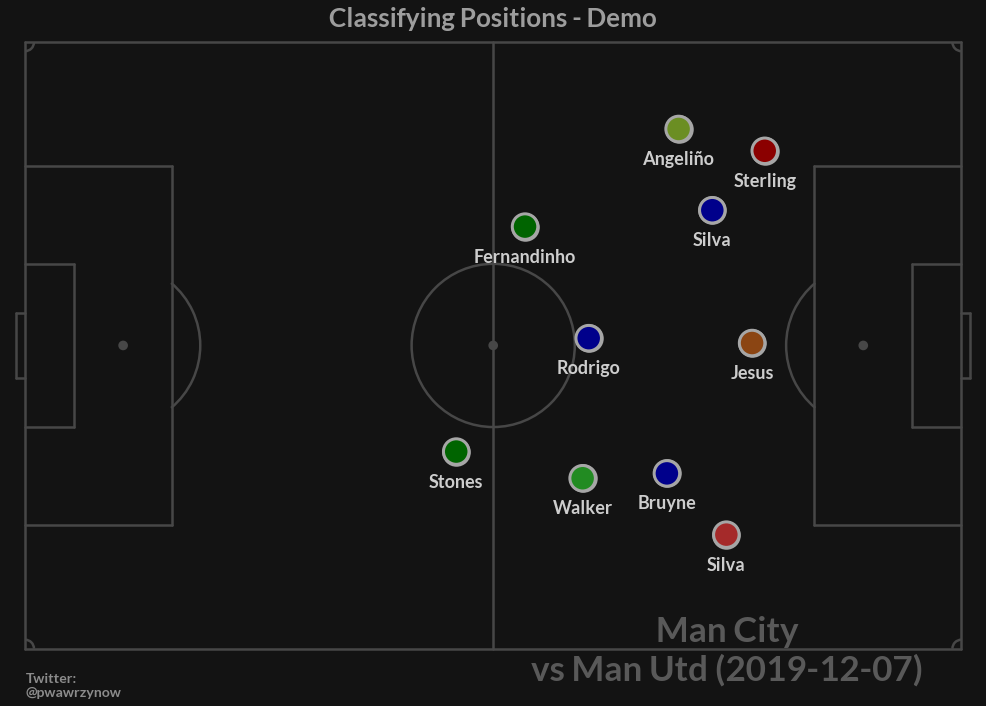

In [7]:
from matplotlib import pyplot as plt
from matplotlib import animation
from field import draw_field
from plot import set_style
import numpy as np

def reverse_venue(venue):
    return 'home' if venue == 'away' else 'away'

color_pos = {
    'CB': 'darkgreen',
    'LB': 'olivedrab',
    'RB': 'forestgreen',
    'CM': 'darkblue',
    'LW': 'darkred',
    'RW': 'brown',
    'ST': 'saddlebrown',
}

class ScatterAnimator():
    def __init__(self):
        self.fig = plt.figure(figsize=(15, 10))
        self.ax = plt.axes([0.05, 0.05, 0.9, 0.9])
        set_style()
        draw_field(self.ax, correct_aspect=True, arrow=False)
        self.ax.set_title('Classifying Positions - Demo', weight=600, fontsize=26, pad=11, alpha=0.75)
        self.fig.text(0.067, 0.012, 'Twitter:\n@pwawrzynow', ha='left', weight=600, fontsize=14, alpha=0.65)

    def setup(self):
        self.elements = []
        self.elements.append(self.ax.scatter([], [],
                    marker='o',
                    s=650,
                    linewidths=3,
                    edgecolors='0.65',
                    zorder=1000))
        data = np.array([proba_df['x'], proba_df['y']]).T
        self.elements[0].set_offsets(data)
        self.elements.append(self.ax.annotate("", (78.75, -0.25), linespacing=1.2, va='center', ha='center', weight=600, fontsize=35, alpha=1, color='0.35', zorder=1001))

        self.players = []
        for _, row in proba_df.iterrows():
            self.players.append(row['name'].split(' ')[-1])
            self.elements.append(self.ax.annotate(
                    f"",
                    (row['x'], row['y']-4),
                    ha='center',
                    zorder=1001,
                    weight=600,
                    fontsize=18
            ))

        return self.elements

    def animate(self, i):
        if i < len(sn_assignments):
            self.elements[0].set_color(np.vectorize(color_pos.get)(sn_assignments[i]))
            self.elements[0].set_edgecolor('0.65')
            self.elements[0].set_linewidth(3)
            self.elements[0].set_sizes([650]*10)

            self.elements[1].set_text(f"Generation #{sn_generations[i]}\nScore: {'{0:g}'.format(np.round(sn_scores[i], 0))}")

            for i_label in range(2, len(self.elements)):
                self.elements[i_label].set_text(f"{sn_assignments[i][i_label-2]}")
        else:
            #self.elements[0].set_offsets([], [])
            self.elements[1].set_text(f"{data[f'{venue}_name']}\nvs {data[f'{reverse_venue(venue)}_name']} ({data['date']})")

            for i_label in range(2, len(self.elements)):
                self.elements[i_label].set_text(f"{self.players[i_label-2]}")
            

        return self.elements

    def save(self):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.setup, frames=len(sn_assignments)+1, interval=20, blit=True)
        anim.save(f"{data[f'{venue}_name']}_vs_{data[f'{reverse_venue(venue)}_name']}_{data['date']}.gif", writer='pillow', fps=0.375)

animator = ScatterAnimator()
animator.save()

['K. Walker',
 'J. Stones',
 'R. Sterling',
 'G. Jesus',
 'A. Angeliño',
 'R. Rodrigo',
 'K. Bruyne',
 'B. Silva',
 'D. Silva',
 'F. Fernandinho']

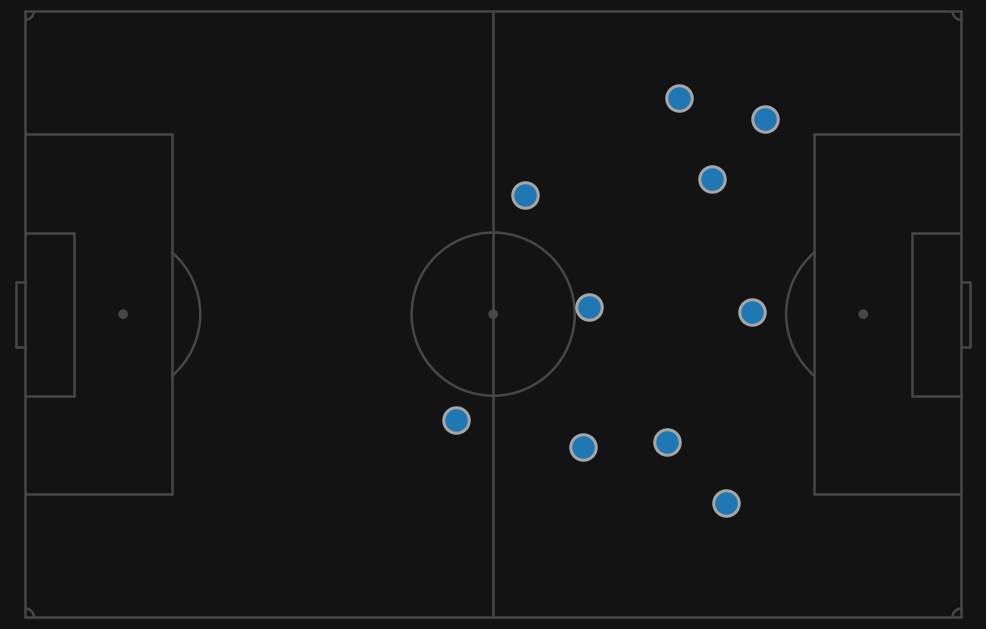

In [43]:
animator = ScatterAnimator()
animator.setup()
animator.players